In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import itertools
import matplotlib
import joblib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/store.csv")
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
store_daily_sales = df.groupby(['date', 'store']).agg({'sales': 'sum'}).reset_index()
store_daily_sales

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032
...,...,...,...
18255,2017-12-31,6,2009
18256,2017-12-31,7,1831
18257,2017-12-31,8,3205
18258,2017-12-31,9,2774


In [ ]:
filt = store_daily_sales['store'] == 1
store_1_df = store_daily_sales[filt]
store_1_df

,date,store,sales
0,2013-01-01,1,1316
10,2013-01-02,1,1264
20,2013-01-03,1,1305
30,2013-01-04,1,1452
40,2013-01-05,1,1499
...,...,...,...
18210,2017-12-27,1,1837
18220,2017-12-28,1,1951
18230,2017-12-29,1,2116
18240,2017-12-30,1,2304


In [ ]:
store_1_df.set_index('date', inplace=True)
store_1_df

,store,sales
date,,
2013-01-01,1,1316
2013-01-02,1,1264
2013-01-03,1,1305
2013-01-04,1,1452
2013-01-05,1,1499
...,...,...
2017-12-27,1,1837
2017-12-28,1,1951
2017-12-29,1,2116


In [ ]:
store_1_df.drop('store',axis=1,inplace=True)

In [ ]:
def train_test_split_timeseries(X,y):
    X_train,y_train = X[:-30],y[:-30]
    X_test,y_test = X[-30:],y[-30:]
    return X_train,y_train,X_test,y_test

In [ ]:
def get_timeseries_metrics(y_true,y_pred):
  mae = tf.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.metrics.mean_squared_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  #mape = (100 / len(y_true)) * tf.abs(tf.reduce_sum((y_true-y_pred)/y_true))


  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy()}

In [ ]:
timesteps = store_1_df.index.to_numpy()
sales = store_1_df['sales'].to_numpy()

In [ ]:
X_train,y_train,X_test,y_test=train_test_split_timeseries(timesteps,sales)
len(X_train),len(y_train),len(X_test),len(y_test)

(1796, 1796, 30, 30)

**N-Beats**

In [ ]:
WINDOW_SIZE = 3
HORIZON = 1

In [ ]:
store_1_df_nbeats = store_1_df.copy()
store_1_df_nbeats.head()

,sales
date,
2013-01-01,1316
2013-01-02,1264
2013-01-03,1305
2013-01-04,1452
2013-01-05,1499


In [ ]:
for i in range(WINDOW_SIZE):
  store_1_df_nbeats[f"sales {i+1}"] = store_1_df_nbeats["sales"].shift(periods=i+1)
store_1_df_nbeats

,sales,sales 1,sales 2,sales 3
date,,,,
2013-01-01,1316,NaN,NaN,NaN
2013-01-02,1264,1316.0,NaN,NaN
2013-01-03,1305,1264.0,1316.0,NaN
2013-01-04,1452,1305.0,1264.0,1316.0
2013-01-05,1499,1452.0,1305.0,1264.0
...,...,...,...,...
2017-12-27,1837,1843.0,1576.0,2384.0
2017-12-28,1951,1837.0,1843.0,1576.0
2017-12-29,2116,1951.0,1837.0,1843.0


In [ ]:
x = store_1_df_nbeats.dropna().drop("sales",axis = 1)
y = store_1_df_nbeats.dropna()["sales"]

In [ ]:
X_train,y_train,X_test,y_test = train_test_split_timeseries(x,y)
len(X_train), len(y_train), len(X_test), len(y_test)

(1793, 1793, 30, 30)

In [ ]:
# train features and labels
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

# test featuresn and labels
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# zipping features and labels to tuple
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

In [ ]:
BATCH_SIZE = 32
# data pipeline and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_pred(model,input_data):
  pred = model.predict(input_data)
  return tf.squeeze(pred)


In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size :int,
               theta_size :int,
               horizon : int,
               n_neurons :int,
               n_layers :int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_layers = n_layers
    self.n_neurons = n_neurons

    #Block contains 4 fully connected layers with each relu activations
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers) ]
    # output of block is theta layer theta_backcast, theta_forecast
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear")

  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
      #x = tf.keras.layers.Dropout(0.5)(x)

    theta = self.theta_layer(x)
    # Output backcast and forecast
    backcast,forecast = theta[:,:self.input_size],theta[:,-self.horizon:]
    return backcast,forecast







In [ ]:
EPOCHS = 200
N_STACKS = 30
N_NEURONS = 512
N_LAYERS = 4

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON
INPUT_SIZE,THETA_SIZE

(3, 4)

In [ ]:
%time
tf.random.set_seed(42)

# Set up instances
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name="InitialBlck")


# Create input to stack
stack_input = tf.keras.layers.Input(shape=INPUT_SIZE,name="stack_input")

# Create initial backcast and forecast (backcast + forecast)
backcast,forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input,backcast],name="subtract_00")

# Create stack of block layers
for i,_ in enumerate(range(N_STACKS-1)):

  # Use the NBeatsBlock to calculate the backcast as well the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals)


  # Create  double resiudal stacking
  residuals = tf.keras.layers.subtract([residuals,backcast],name=f"subtracted_{i}")
  forecast = tf.keras.layers.add([forecast,block_forecast],name=f"add_{i}")

n_beats_model = tf.keras.Model(inputs = stack_input,outputs = forecast)

n_beats_model.compile(loss="mae",
                      optimizer = tf.keras.optimizers.Adam())

n_beats_model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=test_dataset,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                             patience=100,
                                                             restore_best_weights=True)])


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs
Epoch 1/200
57/57 [==============================] - 55s 345ms/step - loss: 646.9143 - val_loss: 279.3226
Epoch 2/200
57/57 [==============================] - 18s 315ms/step - loss: 244.5293 - val_loss: 243.3288
Epoch 3/200
57/57 [==============================] - 19s 326ms/step - loss: 238.6239 - val_loss: 173.9435
Epoch 4/200
57/57 [==============================] - 21s 363ms/step - loss: 219.7110 - val_loss: 206.4327
Epoch 5/200
57/57 [==============================] - 20s 358ms/step - loss: 220.1377 - val_loss: 175.0514
Epoch 6/200
57/57 [==============================] - 20s 344ms/step - loss: 213.0758 - val_loss: 167.3448
Epoch 7/200
57/57 [==============================] - 20s 345ms/step - loss: 218.6396 - val_loss: 186.7081
Epoch 8/200
57/57 [==============================] - 22s 381ms/step - loss: 222.7428 - val_loss: 177.8486
Epoch 9/200
57/57 [==============================] - 19s 341ms/step - loss: 213.4209 - v

In [ ]:
n_beats_model.evaluate(test_dataset)

1/1 [==============================] - 0s 66ms/step - loss: 162.4001


162.400146484375

In [ ]:
n_beats_pred = make_pred(n_beats_model,test_dataset)

1/1 [==============================] - 2s 2s/step


In [ ]:
n_beats_results = get_timeseries_metrics(y_test,n_beats_pred)
n_beats_results

{'mae': 162.40015, 'mse': 118256.16, 'rmse': 343.88394}

In [ ]:
n_beats_df = pd.DataFrame()

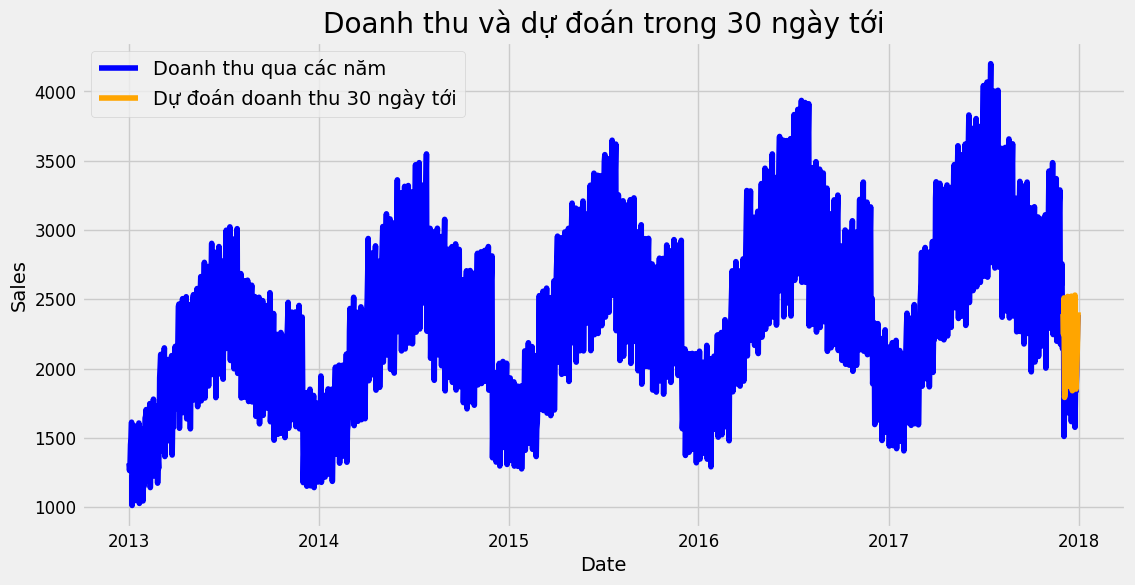

In [ ]:
predicted_prices_df = pd.DataFrame(n_beats_pred, index=y_test.index, columns=['sales'])

plt.figure(figsize=(12, 6))

plt.plot(store_1_df['sales'], label='Doanh thu qua các năm', color='blue')

plt.plot(predicted_prices_df['sales'], label='Dự đoán doanh thu 30 ngày tới', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Doanh thu và dự đoán trong 30 ngày tới')
plt.legend()
plt.show()